# Quantum Algorithms

This notebook contains exercises for the QT course on Quantum Algorithms.

We show an example hybrid algorithm to generate probability distributions. The example has no real-world applications (sampling from probablity distributions can be done classically), but it shows many the aspects of hybrid algorithm in a simple setting. 

The section Bell states contains exercises that can be performed using the QI public website.

<pieter.eendebak@tno.nl>

In [33]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import Parameter, QuantumCircuit
from rich import print as rprint

plt.rcParams["figure.figsize"] = (8, 6)
backend = Aer.get_backend("aer_simulator")

# Hybrid algorithms

In this section you will run (hybrid) algorihms using Python. To install the required dependencies run
```
>>> pip install qiskit quantuminspire
```

## Unfair coin

Using a quantum circuit and a classical optimizer we create a user specified
probability distributions. 
We start with an unfair coin. The outcomes of tossing the coin are head, 
with probability $p$, or tail, with probability $q=1-p$.

We represent our coin with a single qubit and the process of tossing the coin with a measurement
in the computational basis. The outcome $|0\rangle>$ corresonds to head, the outcome $|1\rangle$ corresponds to tail.

To create the random component, we initialize the qubit and then apply a parameterized circuit.

We select a target probability for heads and define the corresponding probability distribution.

In [9]:
p = 0.5 + 0.25 * np.random.random()
target_distribution = {0: p, 1: 1 - p}

Hybrid algorithms consist of 3 components: the parameterized ansatz, the objective function (often quantum) and the classical optimizer. We start with the ansatz for our problem. The ansatz is a single-qubit circuit. Since our problem has only a single degree of freedom (the probablity $p$), we try a ciruit with only a single parameter.

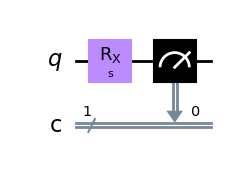

In [10]:
s = Parameter("s")


def generate_ansatz(params):
    qc = QuantumCircuit(1, 1)
    qc.rx(params[0], 0)
    qc.measure(0, 0)
    return qc


qc = generate_ansatz([s])
qc.draw(output="mpl")

The objective function compares the generated distribution with the target distribution.

In [11]:
def counts_to_distr(counts) -> dict[int, float]:
    """Convert Qiskit result counts to a dictionary

    The dictionary has integers as keys, and pseudo-probabilities as values.
    """
    n_shots = sum(counts.values())
    output_distr = {int(k, 2): v / n_shots for k, v in counts.items()}
    return {k: output_distr[k] for k in sorted(output_distr)}


def objective_function(params, target_distribution, backend):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = generate_ansatz(params)
    result = backend.run(qc).result()
    # Convert the result to a dictionary with probabilities
    output_distr = counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(abs(target_distribution.get(i, 0) - output_distr.get(i, 0)) for i in range(2**qc.num_qubits))
    return cost

For the classical optimizer we use [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html).

In [12]:
optimizer = SPSA(maxiter=500)

# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
params = np.random.rand(1)
F = partial(objective_function, target_distribution=target_distribution, backend=backend)
result = optimizer.minimize(fun=F, x0=params)

# Obtain the output distribution using the final parameters
qc = generate_ansatz(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distr = counts_to_distr(counts)
output_distr = {k: output_distr[k] for k in sorted(output_distr)}

print("Parameters Found:", result.x)
print(f"Target Distribution: {target_distribution}")
print("Obtained Distribution: {output_distr}")
print("Cost:", F(result.x))

Parameters Found: [1.1850626]
Target Distribution: {0: 0.6762797244288625, 1: 0.3237202755711375}
Obtained Distribution: {output_distr}
Cost: 0.036112426142274945


In [25]:
# %% Sample 10 times from the distribution to simulate a coin flip
if 0:
    print(f"p {p:.3f}")
    for ii in range(10):
        counts = backend.run(qc, shots=1).result().get_counts()
        value = "head" if counts.get("0", 0) == 1 else "tail"
        print(f"toss {ii}: {value}")

Side note : how much variation do we expect in a generated distribution?

In [38]:
N = 1024  # default number of shots for backend
px = np.array(list(target_distribution.values()))
s = np.sqrt(px * (1 - px) / N)
print(f"p0 {p0}: Expected std in measurement at {N} shots: {s}")

p0 [0.29021911 0.21354532 0.1136651  0.38257048]: Expected std in measurement at 1024 shots: [0.01473139 0.01473139 0.01473139]


## Exercise: QI SDK
Use the QI SDK to sample from the probability distribution on a QI backend.
Options are the `QX single-node simulator`  or `starmon-5` 

Note: you need an account for this. For details see https://github.com/QuTech-Delft/quantuminspire

### Solution

In [28]:
from quantuminspire.credentials import get_token_authentication, load_account
from quantuminspire.qiskit import QI

number_of_samples = 15

authentication = get_token_authentication(load_account())

backend_name = "QX single-node simulator"
# backend_name = "Starmon-5"
QI.set_authentication(authentication)
qi_backend = QI.get_backend(backend_name)
number_of_shots = 2 * 2048
qi_backend.options.shots = number_of_shots  # for starmon-5 overhead is in compilation


r = qi_backend.run(qc, shots=number_of_samples).result()

samples = [int(v, 0) for v in r.results[0].data.memory]
print(f"{len(samples)} samples for p={p:.2f}: {samples}")

# Hint: for starmon-5 one needs to embed the single-qubit circuit in a 5 qubit circuit.
# See qtt.utils.qiskit.circuits.integrate_circuit and qiskit.result.marginal_counts

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(s_0), Parameter(s_1), Parameter(s_2)])]'

In [27]:
# Not working, see https://github.com/QuTech-Delft/quantuminspire/issues/155https://github.com/QuTech-Delft/quantuminspire/issues/155
if 0:
    for ii in range(10):
        counts = qi_backendqi_backend.run(qc, shots=1).result().get_counts()
        value = "head" if counts.get("0", 0) == 1 else "tail"
        print(f"toss {ii}: {value}")

## Exercise: convergence
Show the convergence of the classical optimizer
Add a callback method to the SPSA constructor to record the optimization values at each step.
Plot the result as a function of the iteration step

### Hint

Install qtt using `!pip install qttpte`. One can then use the `OptimizerCallback` class

### Solution

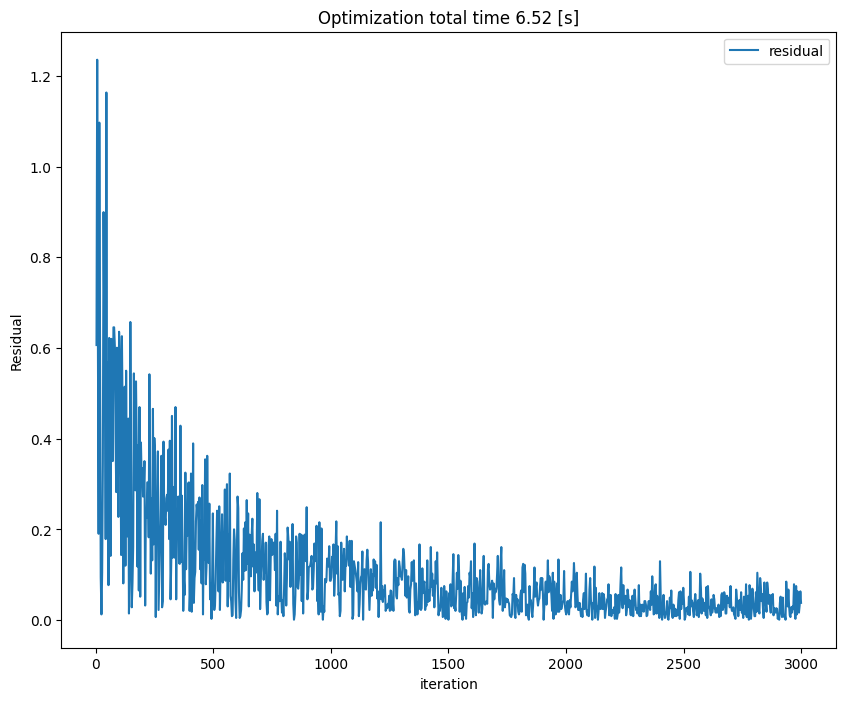

In [22]:
from qtt.utilities.optimization import OptimizerCallback

callback = OptimizerCallback()
optimizer = SPSA(maxiter=1000, callback=callback.qiskit_callback)

params = np.random.rand(3)
result = optimizer.minimize(fun=F, x0=params)
callback.plot()

# Remarks: note that the optimization was fast. Within a few iterations we reached a steady state where the cost function

## Exercise: create a probability distribution for a 4-sided dice

Variation: create an $2^k$-sided dice

### Solution

{0: 0.29021911121631283, 1: 0.21354531771765717, 2: 0.11366509515416066, 3: 0.3825704759118694}

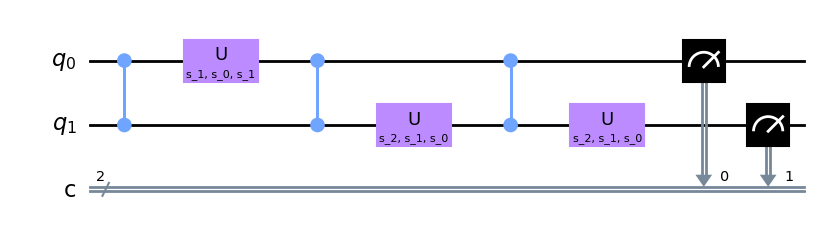

In [31]:
number_of_qubits = 2
m = 2**number_of_qubits
p0 = np.random.random(m) + 0.2
p0 = p0 / np.sum(p0)
target_distribution = {k: p0[k] for k in range(m)}


def generate_ansatz(params):
    qc = QuantumCircuit(number_of_qubits, number_of_qubits)
    qc.cz(0, 1)
    qc.u(params[1], params[0], params[1], 0)
    qc.cz(0, 1)
    qc.u(params[2], params[1], params[0], 1)
    qc.cz(0, 1)
    qc.u(params[2], params[1], params[0], 1)
    for ii in range(number_of_qubits):
        qc.measure(ii, ii)
    return qc


qc = generate_ansatz([Parameter(f"s_{i}") for i in range(3)])

rprint(target_distribution)
qc.draw(output="mpl")

In [30]:
def objective_function2(params, target_distribution):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    qc = generate_ansatz(params)
    result = backend.run(qc).result()
    output_distr = counts_to_distr(result.get_counts())
    cost = sum(abs(target_distribution.get(i, 0) - output_distr.get(i, 0)) for i in range(2**qc.num_qubits))
    return cost


F = partial(objective_function, target_distribution=target_distribution, backend=backend)
F([0.1, 0.2, 0.3])

1.4554446921136082

In [32]:
optimizer = SPSA(maxiter=300)

params = np.random.rand(3)
result = optimizer.minimize(fun=F, x0=params)

# Obtain the output distribution using the final parameters
qc = generate_ansatz(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distr = counts_to_distr(counts)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", F(result.x))

# %%
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.figure(100)
plt.clf()
plot_histogram([target_distribution, output_distr], ax=plt.gca(), legend=["Target", "Generated"])
plt.legend()
# plot_histogram(target_distribution, ax=plt.gca())
# plot_histogram(output_distr, ax=plt.gca())

KeyboardInterrupt: 

## Exercise: generate a (fair) 3-sided dice

This requires some creativity, since 3 is not a power of 2.

### Solution

This is a bit tricky, as our measurements always result in 2^k states.
We could cheat a bit and generate 4 values and just discard the third component, but this requires classical processing which we want to avoid.
So we cheat just a tiny bit: we take 2-qubits and assign the outcomes as: $|00\rangle$ -> side 1, $|01\rangle$ -> side 2, $|10\rangle$ -> side 3 and $|11\rangle$ -> side 3
We have to modify the objective method for this though

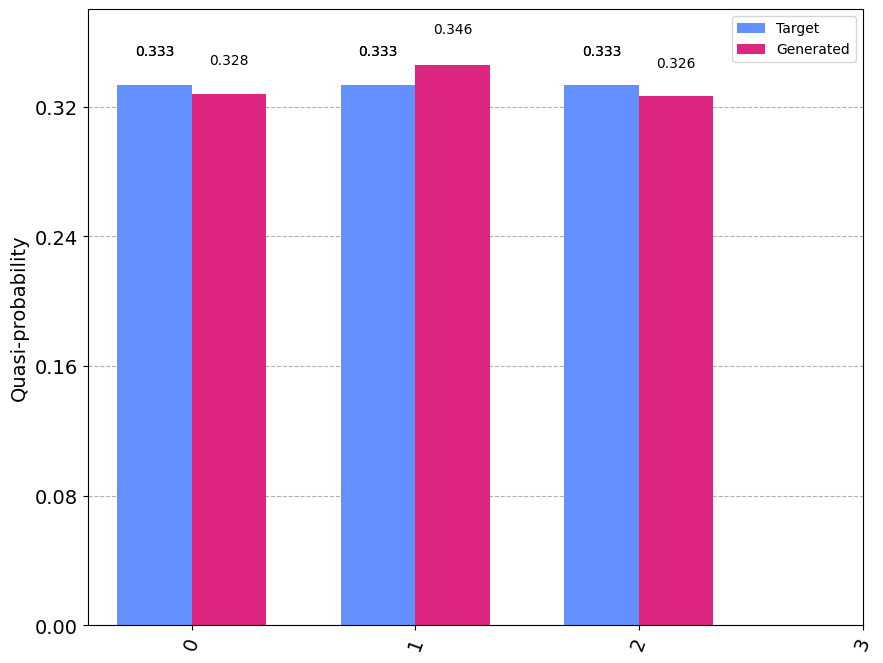

In [36]:
import copy

from qiskit.visualization import plot_histogram


def distrubution_to_three_sided(output_distr):
    output_distr = copy.copy(output_distr)
    output_distr[2] = output_distr.get(2, 0) + output_distr.get(3, 0)
    output_distr[3] = 0
    return output_distr


def objective_function(params, target_distribution):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    qc = generate_ansatz(params)
    result = backend.run(qc).result()
    output_distr = counts_to_distr(result.get_counts())
    output_distr = distrubution_to_three_sided(output_distr)
    cost = sum(abs(target_distribution.get(i, 0) - output_distr.get(i, 0)) for i in range(2**qc.num_qubits))
    return cost


target_distribution = {0: 1 / 3, 1: 1 / 3, 2: 1 / 3}
F = partial(objective_function, target_distribution=target_distribution)
result = optimizer.minimize(fun=F, x0=params)

# %%
qc = generate_ansatz(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distr = counts_to_distr(counts)
output_distr = distrubution_to_three_sided(output_distr)

plt.figure(100)
plt.clf()
plot_histogram([target_distribution, output_distr], ax=plt.gca(), legend=["Target", "Generated"])
plt.legend();

# Bell states

In this section you will run circuits using the QI public website. The link is

https://www.quantum-inspire.com/projects/new


The Bell state is the prime example of an entangled state. In can be created with the following quantum circuit.

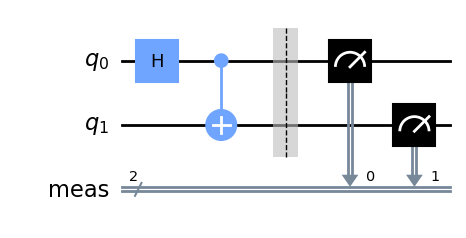

In [2]:
from qiskit import QuantumCircuit

bell = QuantumCircuit(2)
bell.h(0)
bell.cnot(0, 1)
bell.measure_all()
bell.draw(output="mpl")

## Exercise: program a Bell state on the QI website

### Solution

![qi-website-bell-state.png](attachment:a06e02e4-a96b-4d1a-993a-57021bc7bd25.png)

## Exercise: different Bell states

The Bell state introduced above is used most often, in examples, but there are in fact 4 2-qubit Bell states. The first two are

$$|\Phi^+ \rangle > = \frac{|00> + |11>}{2}, |\Phi^- \rangle > = \frac{|00> - |11>}{2}$$

Together the 4 Bell states span the entire 4 dimensional state space of a 2-qubit system.

What could the remaining 2 Bell states be?

### Solution

$$|\Psi^+ \rangle > = \frac{|01> + |10>}{2}, |\Psi^- \rangle > = \frac{|01> - |10>}{2}$$

## Exercise: programming different Bell states

Program the two other Bell states

### Solution

The $|\Phi^-\rangle$ state can be constructed with

```
qubits 2
H q[0]
CNOT q[0], q[1]
X q[1]
```

## Exercise: GHZ states

A generalization of the Bell state is the GHZ ([Greenberger-Horne-Zeiliger](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_statehttps://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state)) state. The GHZ state has applications
in quantum communication and as a building block in quantum algorithms. For a 3-qubit system it is

$$\frac{|000\rangle + |111\rangle}{2} $$

Program the GHZ state and measure the result.

### Solution

```
# GHZ state
qubits 3
H q[0]
CNOT q[0], q[1]
CNOT q[0], q[2]
```
